# Requirements

In [30]:
# Add as many imports as you need.
import pandas as pd
import numpy as np
import keras
from keras.layers import Input, Dense, LSTM, Embedding, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **close price** of the Dow Jones Industrial Average index. To accomplish this use data from the past 7 days, which includes numeric information and news information. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast one future step for the index price (the following day).


## The DIJA Dataset

This dataset consists of daily price records for the value of the Dow Jones Industrial Average index. The dataset includes the following attributes:

- Date - date in the format YYYY-MM-DD,
- Open - open price of the index on the specified date
- Close - close price of the index on the specified date
- High - high price of the index on the specified date
- Low - low price of the index on the specified date
- Volume - number of trades



## The Reddit News Dataset

This dataset consists of news headlines for a certain date that might impact the price:

- Date - date in the format YYYY-MM-DD,
- News - news headline scraped from Reddit

<b>Note: You might have multiple headlines for each date. The number of news per date might not be the same for each date. <b>

Load the datasets into a `pandas` data frame.

In [2]:
# Write your code here. Add as many boxes as you need.
df_stock = pd.read_csv("data/DJIA_table.csv")
df_stock

,Date,Open,High,Low,Close,Volume
0,7/1/2016,17924.24023,18002.38086,17916.91016,17949.36914,82160000
1,6/30/2016,17712.75977,17930.60938,17711.80078,17929.99023,133030000
2,6/29/2016,17456.01953,17704.50977,17456.01953,17694.67969,106380000
3,6/28/2016,17190.50977,17409.72070,17190.50977,17409.72070,112190000
4,6/27/2016,17355.21094,17355.21094,17063.08008,17140.24023,138740000
...,...,...,...,...,...,...
1984,8/14/2008,11532.07031,11718.28027,11450.88965,11615.92969,159790000
1985,8/13/2008,11632.80957,11633.78027,11453.33984,11532.95996,182550000
1986,8/12/2008,11781.70020,11782.34961,11601.51953,11642.46973,173590000
1987,8/11/2008,11729.66992,11867.11035,11675.53027,11782.34961,183190000


In [3]:
df_stock["Date"] = pd.to_datetime(df_stock["Date"])
df_stock.set_index(keys=["Date"], inplace=True)
df_stock.sort_index(inplace=True)
df_stock

,Open,High,Low,Close,Volume
Date,,,,,
2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000
2008-08-11,11729.66992,11867.11035,11675.53027,11782.34961,183190000
2008-08-12,11781.70020,11782.34961,11601.51953,11642.46973,173590000
2008-08-13,11632.80957,11633.78027,11453.33984,11532.95996,182550000
2008-08-14,11532.07031,11718.28027,11450.88965,11615.92969,159790000
...,...,...,...,...,...
2016-06-27,17355.21094,17355.21094,17063.08008,17140.24023,138740000
2016-06-28,17190.50977,17409.72070,17190.50977,17409.72070,112190000
2016-06-29,17456.01953,17704.50977,17456.01953,17694.67969,106380000


In [4]:
df_news = pd.read_csv("data/RedditNews.csv")
df_news

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
...,...,...
73603,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...
73604,2008-06-08,b'Threat of world AIDS pandemic among heterose...
73605,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...
73606,2008-06-08,"b""UK: Identity cards 'could be used to spy on ..."


In [5]:
df_news["Date"] = pd.to_datetime(df_news["Date"])
df_news.set_index(keys=["Date"], inplace=True)
df_news.sort_index(inplace=True)
df_news

,News
Date,
2008-06-08,"b'Marriage, they said, was reduced to the stat..."
2008-06-08,b'Nim Chimpsky: The tragedy of the chimp who t...
2008-06-08,"b""Canada: Beware slippery slope' to censorship..."
2008-06-08,b'EU Vice-President Luisa Morgantini and the I...
2008-06-08,"b""Israeli minister: Israel will attack Iran if..."
...,...
2016-07-01,"Venezuela, where anger over food shortages is ..."
2016-07-01,A Hindu temple worker has been killed by three...
2016-07-01,Ozone layer hole seems to be healing - US &amp...


Merge the datasets (be careful you can get multiple rows per date which is not desirable)

In [6]:
# Write your code here. Add as many boxes as you need.
df = df_stock.merge(df_news, how='left', right_index=True, left_index=True)
df

,Open,High,Low,Close,Volume,News
Date,,,,,,
2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000,b'Georgian troops retreat from S. Osettain cap...
2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000,"b""The 'enemy combatent' trials are nothing but..."
2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000,"b""Breaking: Georgia invades South Ossetia, Rus..."
2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000,b'150 Russian tanks have entered South Ossetia...
2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000,b'Did the U.S. Prep Georgia for War with Russia?'
...,...,...,...,...,...,...
2016-07-01,17924.24023,18002.38086,17916.91016,17949.36914,82160000,"Venezuela, where anger over food shortages is ..."
2016-07-01,17924.24023,18002.38086,17916.91016,17949.36914,82160000,A Hindu temple worker has been killed by three...
2016-07-01,17924.24023,18002.38086,17916.91016,17949.36914,82160000,Ozone layer hole seems to be healing - US &amp...


## Feauture Extraction


1. DIJA Table
Apply a lag of one, up to 7 days to each feature, creating a set of features representing the index price from the previous 7 days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

2. Reddit News Table
Create a numeric representation for the news (for example average embedding or average sentiment). <b> You must create lags of the news features as well since we will not know the news for the future. </b>

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [7]:
# Write your code here. Add as many boxes as you need.
aggregation = {
    col: 'first' for col in df.columns[:-1]
}
aggregation.update({'News': '\n'.join})

In [8]:
aggregation

{'Open': 'first',
 'High': 'first',
 'Low': 'first',
 'Close': 'first',
 'Volume': 'first',
 'News': <function str.join(iterable, /)>}

In [9]:
df = df.groupby('Date').agg(aggregation)
df

,Open,High,Low,Close,Volume,News
Date,,,,,,
2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000,b'Georgian troops retreat from S. Osettain cap...
2008-08-11,11729.66992,11867.11035,11675.53027,11782.34961,183190000,b'Russia angered by Israeli military sale to G...
2008-08-12,11781.70020,11782.34961,11601.51953,11642.46973,173590000,b'U.S. Beats War Drum as Iran Dumps the Dollar...
2008-08-13,11632.80957,11633.78027,11453.33984,11532.95996,182550000,"b""Bush announces Operation Get All Up In Russi..."
2008-08-14,11532.07031,11718.28027,11450.88965,11615.92969,159790000,b'Poland and US agree to missle defense deal. ...
...,...,...,...,...,...,...
2016-06-27,17355.21094,17355.21094,17063.08008,17140.24023,138740000,Angela Merkel said the U.K. must file exit pap...
2016-06-28,17190.50977,17409.72070,17190.50977,17409.72070,112190000,Hong Kong democracy activists call for return ...
2016-06-29,17456.01953,17704.50977,17456.01953,17694.67969,106380000,A chatbot programmed by a British teenager has...


In [10]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
News      0
dtype: int64

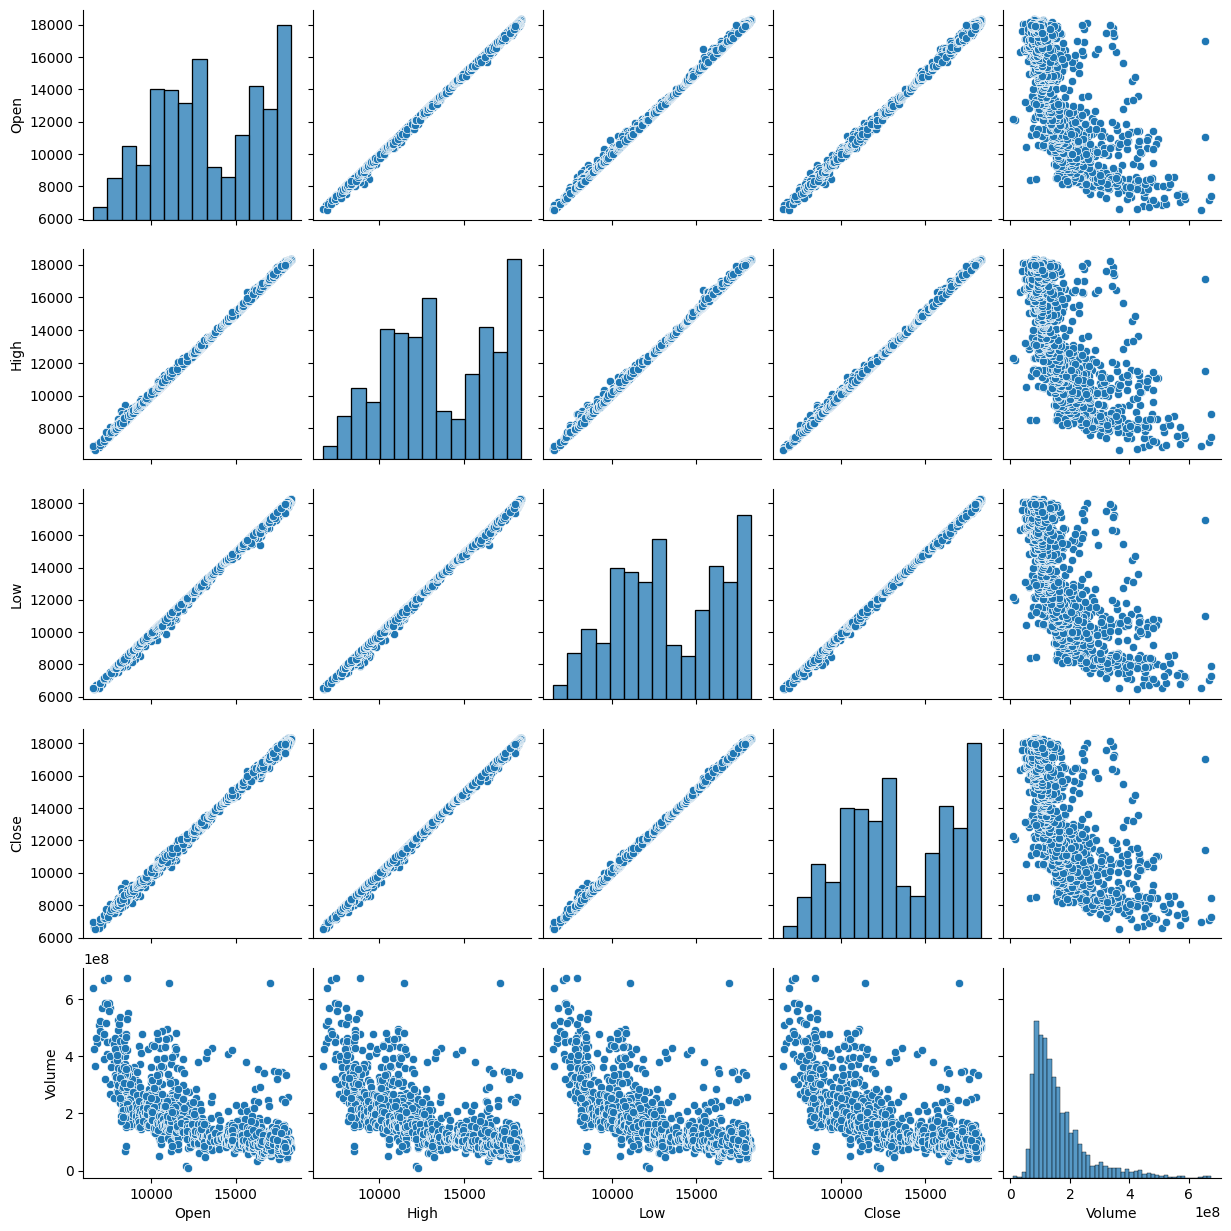

In [15]:
sns.pairplot(df)

In [17]:
numeric_feature_names = df.columns[:-1]
numeric_feature_names

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [18]:
lags = 7
for i in range(1, lags + 1):
  for col in numeric_feature_names:
    df[f'{col}_lag_{i}'] = df[col].shift(i)

In [19]:
df

,Open,High,Low,Close,Volume,News,Open_lag_1,High_lag_1,Low_lag_1,Close_lag_1,...,Open_lag_6,High_lag_6,Low_lag_6,Close_lag_6,Volume_lag_6,Open_lag_7,High_lag_7,Low_lag_7,Close_lag_7,Volume_lag_7
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000,b'Georgian troops retreat from S. Osettain cap...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-11,11729.66992,11867.11035,11675.53027,11782.34961,183190000,b'Russia angered by Israeli military sale to G...,11432.08984,11759.95996,11388.04004,11734.32031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-12,11781.70020,11782.34961,11601.51953,11642.46973,173590000,b'U.S. Beats War Drum as Iran Dumps the Dollar...,11729.66992,11867.11035,11675.53027,11782.34961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-13,11632.80957,11633.78027,11453.33984,11532.95996,182550000,"b""Bush announces Operation Get All Up In Russi...",11781.70020,11782.34961,11601.51953,11642.46973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-14,11532.07031,11718.28027,11450.88965,11615.92969,159790000,b'Poland and US agree to missle defense deal. ...,11632.80957,11633.78027,11453.33984,11532.95996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-27,17355.21094,17355.21094,17063.08008,17140.24023,138740000,Angela Merkel said the U.K. must file exit pap...,17946.63086,17946.63086,17356.33984,17400.75000,...,17733.43945,17733.43945,17602.77930,17675.16016,248680000.0,17602.23047,17754.91016,17471.28906,17733.09961,91950000.0
2016-06-28,17190.50977,17409.72070,17190.50977,17409.72070,112190000,Hong Kong democracy activists call for return ...,17355.21094,17355.21094,17063.08008,17140.24023,...,17736.86914,17946.35938,17736.86914,17804.86914,99380000.0,17733.43945,17733.43945,17602.77930,17675.16016,248680000.0
2016-06-29,17456.01953,17704.50977,17456.01953,17694.67969,106380000,A chatbot programmed by a British teenager has...,17190.50977,17409.72070,17190.50977,17409.72070,...,17827.33008,17877.83984,17799.80078,17829.73047,85130000.0,17736.86914,17946.35938,17736.86914,17804.86914,99380000.0


In [20]:
df = df.dropna(axis=0)

In [21]:
numeric_feature_names = df.columns[7:]

In [22]:
text_feature_names = 'News'
target = 'Close'

In [23]:
numeric_features = df[numeric_feature_names]
text_features = df[text_feature_names]

In [24]:
Y = df[target]

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [25]:
# Write your code here. Add as many boxes as you need.
X_train_numeric, X_test_numeric, Y_train, Y_test = train_test_split(numeric_features, Y, shuffle=False, test_size=0.2)

In [26]:
X_train_text, X_test_text, _, _ = train_test_split(text_features, Y, shuffle=False, test_size=0.2)

## Feauture Scaling
Scale the extracted features using an appropriate scaler if needed.

In [27]:
# Write your code here. Add as many boxes as you need.
scaler = MinMaxScaler()
X_train_numeric = scaler.fit_transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

In [32]:
max_words = 1000

In [33]:
tokenizer = Tokenizer(max_words)
tokenizer.fit_on_texts(X_train_text.values)
X_train_text = tokenizer.texts_to_sequences(X_train_text.values)
X_test_text = tokenizer.texts_to_sequences(X_test_text.values)
X_train_text = pad_sequences(X_train_text, 64)
X_test_text = pad_sequences(X_test_text, 64)

In [35]:
X_train_text = np.array([np.array(encoding) for encoding in X_train_text])
X_test_text = np.array([np.array(encoding) for encoding in X_test_text])

In [36]:
X_train = np.concatenate([X_train_numeric, X_train_text], axis=1)
X_test = np.concatenate([X_test_numeric, X_test_text], axis=1)

In [37]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

In [38]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])

In [ ]:
history = model.fit(X_train, Y_train, validation_split=0.2, shuffle=False, epochs=50, batch_size=16)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 5749.8896 - mean_absolute_error: 54.0050 - val_loss: 748.1555 - val_mean_absolute_error: 21.5774
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 626.5382 - mean_absolute_error: 19.0409 - val_loss: 424.7332 - val_mean_absolute_error: 16.0551
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 303.0141 - mean_absolute_error: 13.4700 - val_loss: 323.5956 - val_mean_absolute_error: 13.7544
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 185.5639 - mean_absolute_error: 10.6036 - val_loss: 265.9168 - val_mean_absolute_error: 12.2688
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 124.3201 - mean_absolute_error: 8.6558 - val_loss: 233.0887 - val_mean_absolute_error: 11.4174
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 91.1847 - mean_absolute_error: 7.4804 - val_loss: 213.8046 - val_mean_absolute_error: 10.8693
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 70.4473 - mean_abso

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [ ]:
# Write your code here. Add as many boxes as you need.
X_train_numeric = X_train_numeric.reshape(-1, lags, len(X_train_numeric[0]) // lags)

## Long Short-Term Memory (LSTM) Network


Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [ ]:
# Write your code here. Add as many boxes as you need.

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [ ]:
# Write your code here. Add as many boxes as you need.

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [ ]:
# Write your code here. Add as many boxes as you need.

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

In [ ]:
# Write your code here. Add as many boxes as you need.

Use the trained model to make predictions for the test set.

In [ ]:
# Write your code here. Add as many boxes as you need.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
# Write your code here. Add as many boxes as you need.

Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

In [ ]:
# Write your code here. Add as many boxes as you need.